# About this tutorial
Demonstrates how to access the iSDAsoil data on AWS, how to download a subset of the total data, as well as a quick demo of a potential application. For obtaining soil information at specific point locations, use the [iSDAsoil API](https://www.isda-africa.com/isdasoil/developer/) - this tutorial focuses on downloading soil information for larger areas.

For further information on the layers, visit the [iSDAsoil FAQ](https://www.isda-africa.com/isdasoil/faqs/) and [techincal information](https://www.isda-africa.com/isdasoil/technical-information/) pages.

In [1]:
!pip install requests
!pip install boto3
!pip install pystac

!pip install rasterio
!pip install pyproj
!pip install fsspec
!pip install s3fs


  Using cached botocore-1.20.112-py2.py3-none-any.whl.metadata (5.6 kB)
Using cached botocore-1.20.112-py2.py3-none-any.whl (7.7 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.38.27
    Uninstalling botocore-1.38.27:
      Successfully uninstalled botocore-1.38.27
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.23.0 requires botocore<1.38.28,>=1.38.23, but you have botocore 1.20.112 which is incompatible.
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 107.7 MB/s eta 0:00:00
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1-py

# What data is availble?
First, we can list all of the files available in the iSDAsoil AWS bucket. This consists of data created by iSDA using our machine learning pipeline, but also covariates that were used to predict the soil properties.

iSDAsoil uses the [STAC specification](https://stacspec.org/) to provide metadata about the files we've made available (in the form of `.json` files that live alongside the data). An explanation of STAC is beyond the scope of this tutorial, however we can use the `pystac` library to print out information about the data available in the s3 bucket, including the title, description and URL of the files:

In [2]:
from urllib.parse import urlparse
import boto3
from pystac import STAC_IO, Catalog

#this function allows us to directly query the data on s3
def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme == 's3':
        bucket = parsed.netloc
        key = parsed.path[1:]
        s3 = boto3.resource('s3')
        obj = s3.Object(bucket, key)
        return obj.get()['Body'].read().decode('utf-8')
    else:
        return STAC_IO.default_read_text_method(uri)

STAC_IO.read_text_method = my_read_method

catalog = Catalog.from_file("https://isdasoil.s3.amazonaws.com/catalog.json")

assets = {}

for root, catalogs, items in catalog.walk():
    for item in items:
        print(f"Type: {item.get_parent().title}")
        # save all items to a dictionary as we go along
        assets[item.id] = item
        for asset in item.assets.values():
            if asset.roles == ['data']:
                print(f"Title: {asset.title}")
                print(f"Description: {asset.description}")
                print(f"URL: {asset.href}")
                print("------------")

Type: Soil data
Title: Aluminium, extractable
Description: Aluminium, extractable (log transformed) at soil depths of 0-20cm and 20-50cm, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/aluminium_extractable/aluminium_extractable.tif
------------
Type: Soil data
Title: Depth to bedrock
Description: Depth to bedrock at 0-200cm depth, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/bedrock_depth/bedrock_depth.tif
------------
Type: Soil data
Title: Bulk density, <2mm fraction
Description: Bulk density, <2mm fraction at soil depths of 0-20cm and 20-50cm, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/bulk_density/bulk_density.tif
------------
Type: Soil data
Title: Calcium, extractable
Description: Calcium, extractable (log transformed) at soil depths of 0-20cm and 20-50cm, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/calcium_extra

# Retrieving a subset of the data

One great feature about Cloud-optimised Geotiffs is that we can request a smaller subset of the total data, based upon on any geography that we are interested in. This is especially useful for the iSDAsoil data, where a single file covers the whole of Africa and can therefore go into the tens (or even hundreds) of gigabytes.

To retrieve a smaller subset of the data (e.g. for a specific country or region), all we have to do is specify the upper left and bottom right coordinates of a bounding box, in lat/lon. Let's take a look at a small area in Rwanda. You can view this location on the iSDAsoil frontend by visiting https://www.isda-africa.com/isdasoil/?location=29.710%2C-1.789%2C29.744%2C-1.757

In [7]:
# beware that if you specify a large area, the request can take a long time
start_lat_lon=(-16.468189, 25.403934)
end_lat_lon=(-16.968189,  25.903934)

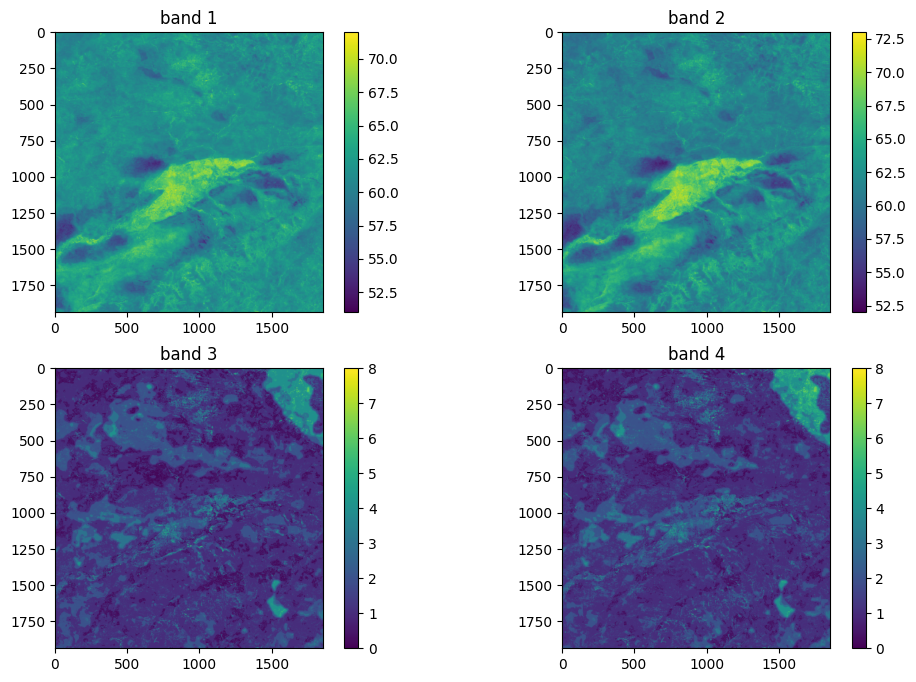

In [8]:
import rasterio as rio
from pyproj import Transformer
import matplotlib.pyplot as plt
import os
import numpy as np


# "https://isdasoil.s3.amazonaws.com/soil_data/ph/ph.tif"
URL=assets["ph"].assets["image"].href
#URL: https://isdasoil.s3.amazonaws.com/soil_data/aluminium_extractable/aluminium_extractable.tif
#URL=assets["ph"].assets["image"].href


def get_data_subset(start_lat_lon, end_lat_lon, file_location):
    '''
    :param start_lat_lon: upper left corner of the bounding box as lat, lon
    :param end_lat_lon: lower right corner of the bounding box as lat, lon
    :param file_location: location of file
    :return: numpy array of the dataset, metadata required for writing back to tiff file
    '''
    with rio.open(file_location) as file:
        transformer = Transformer.from_crs("epsg:4326", file.crs)

        # convert the data from lat/lon to x,y coords of the source dataset crs
        start_coords = transformer.transform(start_lat_lon[0], start_lat_lon[1])
        end_coords = transformer.transform(end_lat_lon[0], end_lat_lon[1])

        # get the location of the pixel at the given location (in lon/lat (x/y) order))
        start_coords= file.index(start_coords[0], start_coords[1])
        end_coords=file.index(end_coords[0], end_coords[1])

        window = rio.windows.Window(start_coords[1], start_coords[0], end_coords[1] - start_coords[1], end_coords[0] - start_coords[0])


        arr = file.read(window=window)

        new_profile = file.profile.copy()

    new_profile.update({
            'height': window.height,
            'width': window.width,
            'count': file.count,
            'transform': file.window_transform(window)
    })

    return arr, new_profile


def plot_raster(arr, title):
    fig, ax = plt.subplots(figsize=(12,8), dpi= 100)
    img = ax.imshow(arr)
    fig.colorbar(img, ax=ax)
    ax.set_title(title)
#     fig.title(title)
#     ax.show()


def plot_grid(arr, titles):
    '''
    plots a grid of 4 rasters
    '''
    fig, axs = plt.subplots(2, 2, figsize=(12,8), dpi= 100)
    count=0
    for i in axs:
        for y in i:
            img = y.imshow(arr[count])
            fig.colorbar(img, ax=y)
            y.set_title(titles[count])
            count+=1


data, metadata = get_data_subset(start_lat_lon, end_lat_lon, URL)

plot_grid(data, [f"band {band}" for band in range(1,5)])

We can see that there are 4 images because the file contains 4 bands. In order to make sense of the data, we need to know what data is represented by each band. Information on the bands is contained in the STAC item:

In [9]:
bands = assets["ph"].assets["image"].properties["eo:bands"]
bands = [val['description'] for val in bands]
bands

['pH, predicted mean at 0-20 cm depth',
 'pH, predicted mean at 20-50 cm depth',
 'pH, standard deviation at 0-20 cm depth',
 'pH, standard deviation at 20-50 cm depth']

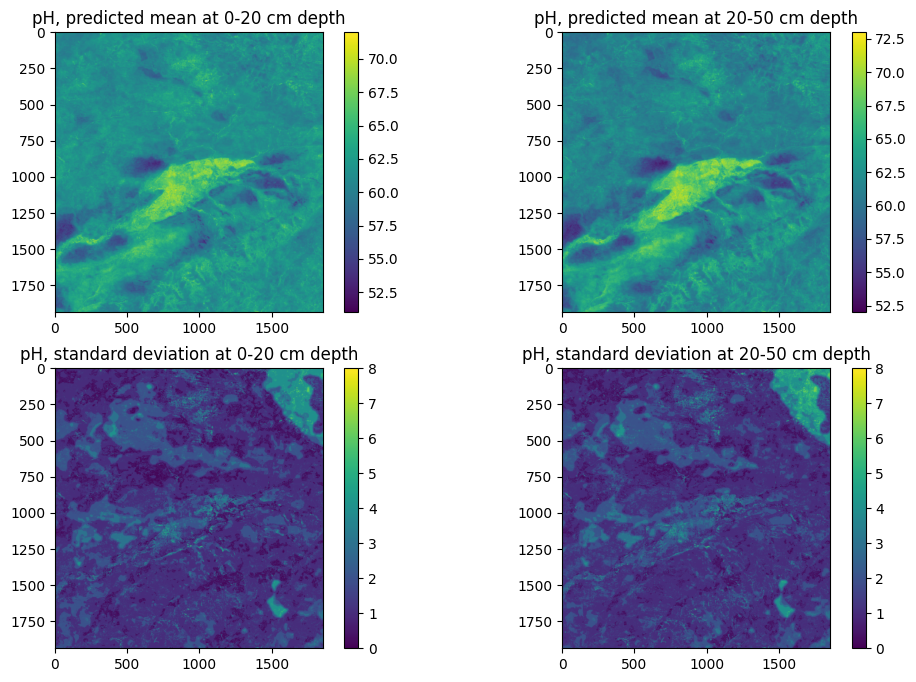

In [10]:
plot_grid(data, bands)

## But wait a second! pH does not go up to 59!

...Indeed it does not, which brings us to the next step: backtransformation.

Due to the way the data has been stored, some layers require backtransformation to normal units before they can be used. Again we can consult the STAC items to see whether this is required, as we have stored any backtransformation information as `extra_fields`. For relevant soil data, we also store the units under `extra_fields`.

In [11]:
conversion=assets['ph'].extra_fields["back-transformation"]
conversion

'x/10'

For convenience, we have created a dictionary of functions that contain all of the backtransformations required for the iSDAsoil data. Let's apply the backtranformation for pH.

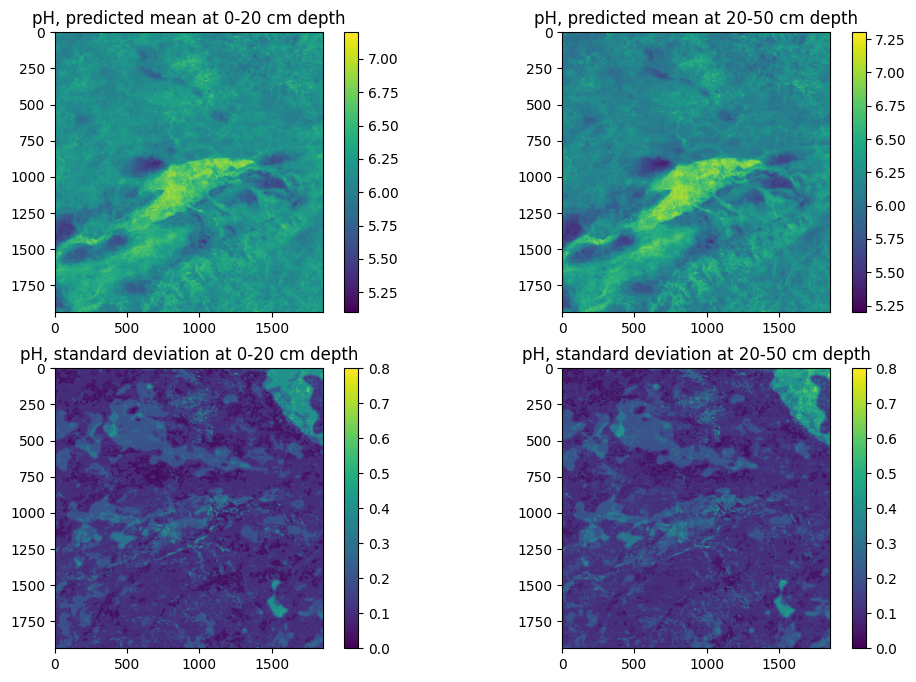

In [12]:
import numpy as np

conversion_funcs = {
    "x": np.vectorize(lambda x: x),
    "x/10": np.vectorize(lambda x: x/10, otypes=["float32"]),
    "x/100": np.vectorize(lambda x: x/100, otypes=["float32"]),
    "expm1(x/10)": np.vectorize(lambda x: np.expm1(x / 10), otypes=["float32"]),
    "%3000": np.vectorize(lambda x: int(x%3000), otypes=["int16"])
}

transformed_data = conversion_funcs[conversion](data)

plot_grid(transformed_data, bands)



If we are just interested in obtaining the data, we can write the image to file:

In [13]:
def write_img_to_file(filename, data, metadata):
    with rio.open(filename, 'w', **metadata) as dest:
        if len(data.shape) == 2:
             data=np.array([data])
        dest.write(data)

# we can use the previously returned Geotiff metadata, but need to update the dtype due to the transformation
metadata.update(
    {
        'dtype': "float32"
    }
)

write_img_to_file("ph_example.tif", transformed_data, metadata)

## Working with categorical data

We might also be interested to see what constraints exist in the soils at this location. One of the layers that we've created is an adaptation of the soil fertility capability classification (FCC) layer, based upon research by [Sanchez et. al (2003)](https://www.sciencedirect.com/science/article/abs/pii/S0016706103000405). This layer aims to give an idea about the specific constraints to soil that may exist at any given location. We have further information on this layer here: https://www.isda-africa.com/isdasoil/faqs/#faq6

Let's plot the FCC layer for the same location:


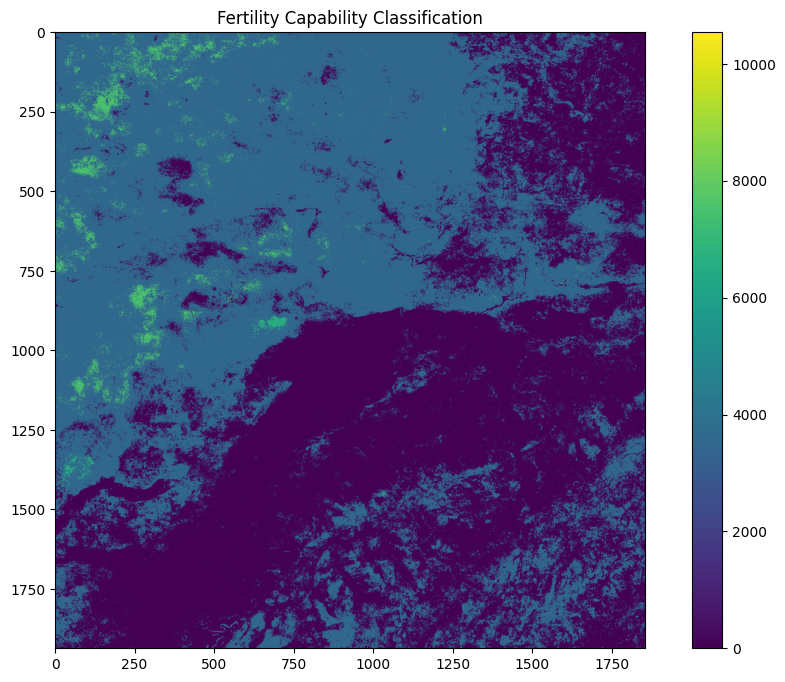

In [14]:
fcc_data, fcc_metadata = get_data_subset(start_lat_lon, end_lat_lon, assets["fcc"].assets["image"].href)
plot_raster(fcc_data[0], "Fertility Capability Classification")

Because `.tif` image files can only store numeric values, we need a separate file that contains the mapping between the integer values in the .tif file and their true meaning. For any categorical data, there is an accompanying metadata file, the details of which are also contained within the STAC item.

For the FCC layer, we can see from the `extra_fields['back-tranformation']` property that we first need to do a transformation (`%3000`) on the data, and then map the numeric values to their string representation.

In [15]:
#get the conversion information and do the backtransformation on the values
fcc_conversion = conversion=assets['fcc'].extra_fields["back-transformation"]
fcc_data = conversion_funcs[fcc_conversion](fcc_data)

#get the metadata file
import pandas as pd
fcc_labels = pd.read_csv(assets['fcc'].assets["metadata"].href, index_col=0)

mappings = {val:fcc_labels.loc[int(val),"Description"] for val in np.unique(fcc_data)}

# print the numeric values stored in the file alongside their string representation
mappings


{np.int16(0): 'No constraints',
 np.int16(4): 'Slope',
 np.int16(8): 'High erosion risk - textual contrast',
 np.int16(36): 'Slope, High erosion risk - steep slope',
 np.int16(128): 'Al toxicity',
 np.int16(512): 'Low K',
 np.int16(516): 'Slope, Low K',
 np.int16(520): 'High erosion risk - textual contrast, Low K',
 np.int16(640): 'Al toxicity, Low K',
 np.int16(1024): 'High leaching potential',
 np.int16(1536): 'Low K, High leaching potential',
 np.int16(1544): 'High erosion risk - textual contrast, Low K, High leaching potential'}

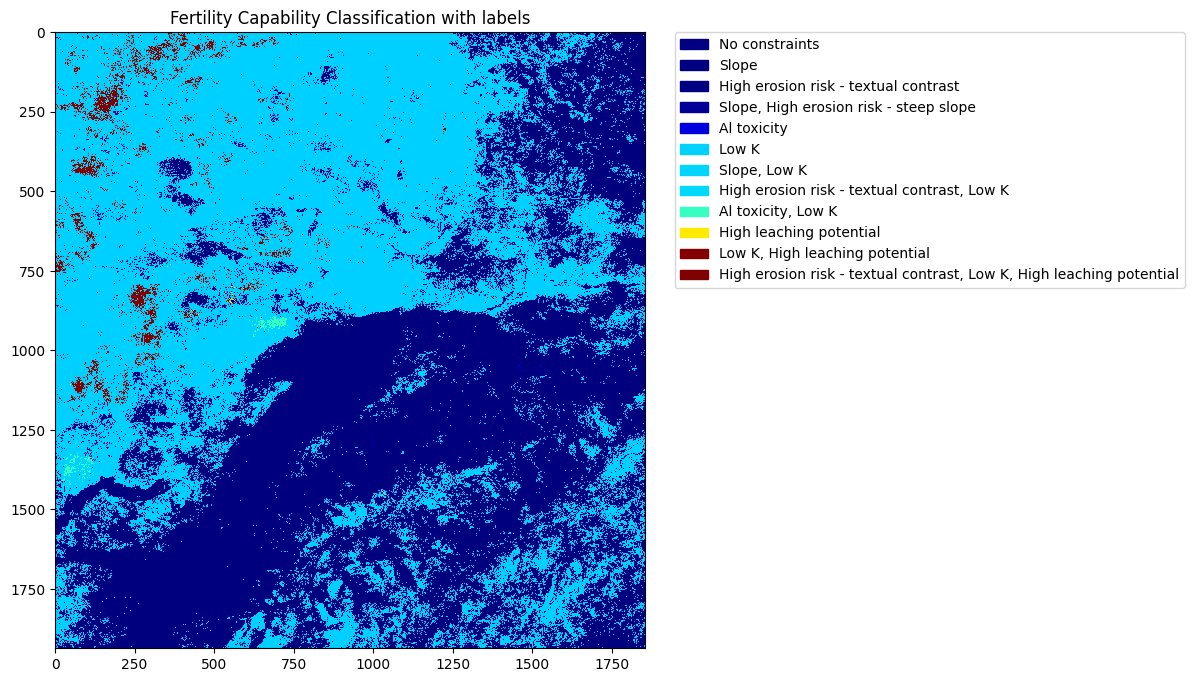

In [17]:
import matplotlib.patches as mpatches

# now plot the FCC layer with labels and a more appropriate colour scheme
plt.figure(figsize=(12,8), dpi= 100)
im = plt.imshow(fcc_data[0], cmap="jet", interpolation='none')
colors = [ im.cmap(im.norm(value)) for value in np.unique(fcc_data[0])]
patches = [mpatches.Patch(color=colors[idx], label=str(mappings[val])) for idx, val in enumerate(np.unique(fcc_data[0]))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title("Fertility Capability Classification with labels")
plt.show()


# A worked example: Estimate liming requirements for an area in Rwanda

Low pH soils are acidic, meaning that there is a lower availability of nutrients to crops, and there is also a greater chance that the plants can be damaged by toxic metals in the soil, such as Aluminium. We can see from the FCC plot above that much of the land is covered by an "Al toxicity" (Aluminium toxicity) constraint.

In order to counteract a low pH soil, many farmers choose to apply lime, a soil additive that can raise the pH to a more neutral level. This in turn means that any fertiliser applied to the soil has a better chance of being taken up by the crop.

Let's create a lime requirement map, using the ph layer at 0-20cm depth:

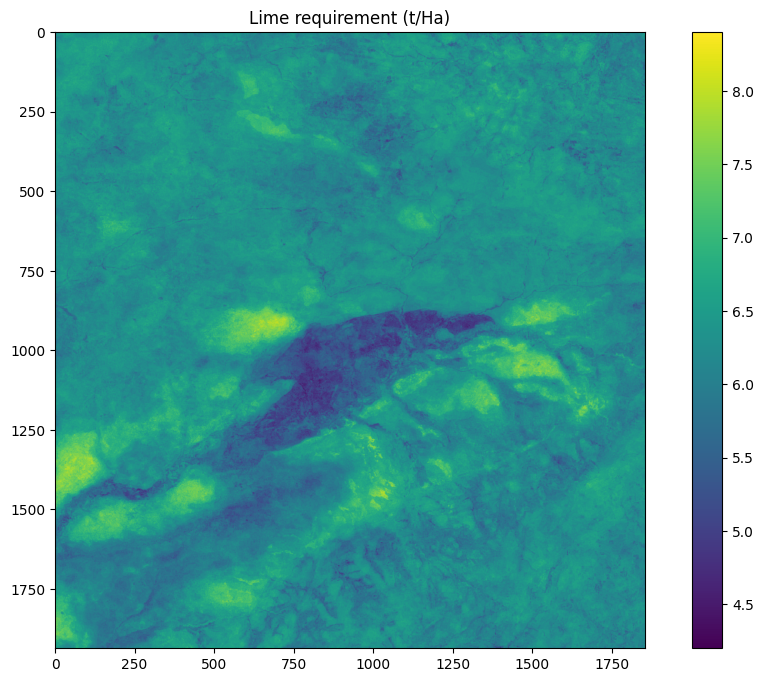

In [27]:
# we want to raise the soil pH to 9.3, so the lime requirement calculation is: (5.3 - {ph}) * 2
lime_req_calc = lambda x: max(0,(9.3 - x)) * 2
lime_req_calc_vectorized = np.vectorize(lime_req_calc)
limereq = lime_req_calc_vectorized(transformed_data[0])
plot_raster(limereq, "Lime requirement (t/Ha)")

We can see that there are areas where no lime is required due to adequate soil pH (dark blue), and some more acidic areas that could benefit from lime.

We can calculate the total lime requirement for the area by summing all of the pixel values and then converting the units from hectares to our 30x30m pixel size.

In [28]:
print(f"Total lime requirement for the area: {np.round(np.sum(limereq)*0.09, 3)} tonnes")

Total lime requirement for the area: 2028570.75 tonnes


However, we can also calculate a lime requirement per pixel, and incorporate our prediction uncertainty in order to give users an idea of the level of confidence we have in the underlying data, and therefore the lime requirement.

Lets get the lime requirement for 2 different locations on the map, calculate a distribution for each location using the uncertainty, and sample from that distribution to generate a lime requirement distribution for each pixel. All will become apparent...

In [29]:
# we can obtain the pixel value for any location by specifying the row and column coordinates

round_val = lambda x: np.format_float_positional(x, 2)

row=40
col=11

loc_a_ph_mean = transformed_data[0][row,col]
loc_a_ph_stdev = transformed_data[2][row,col]
print(f"Location A: pH: {round_val(loc_a_ph_mean)}, standard deviation: {round_val(loc_a_ph_stdev)}")



Location A: pH: 6.1, standard deviation: 0.1


In [32]:
transformed_data[0].shape

(1937, 1856)

In [33]:
# location with low stdev

row=401
col=409

loc_b_ph_mean = transformed_data[0][row,col]
loc_b_ph_stdev = transformed_data[2][row,col]

print(f"Location B: pH: {round_val(loc_b_ph_mean)}, standard deviation: {round_val(loc_b_ph_stdev)}")

Location B: pH: 6.1, standard deviation: 0.4


We can see that if we'd have simply used the mean pH value for both locations (4.9), the lime requirement would be the same:

In [34]:
print(f"Lime requirement for pH of 4.9: {np.format_float_positional(lime_req_calc_vectorized(4.9), 2)} tonnes per hectare (t/ha)")

Lime requirement for pH of 4.9: 8.8 tonnes per hectare (t/ha)


However, if we construct a distribution for pH for each location based upon the mean and standard deviation values, we can then randomly sample from this distribution. We can then apply the liming equation to each random draw from the distribution and plot the results as a histogram:

In [37]:
limereq_a

array([5.8425751 , 6.76179609, 6.42999282, ..., 6.51375572, 6.39016862,
       6.16139844])

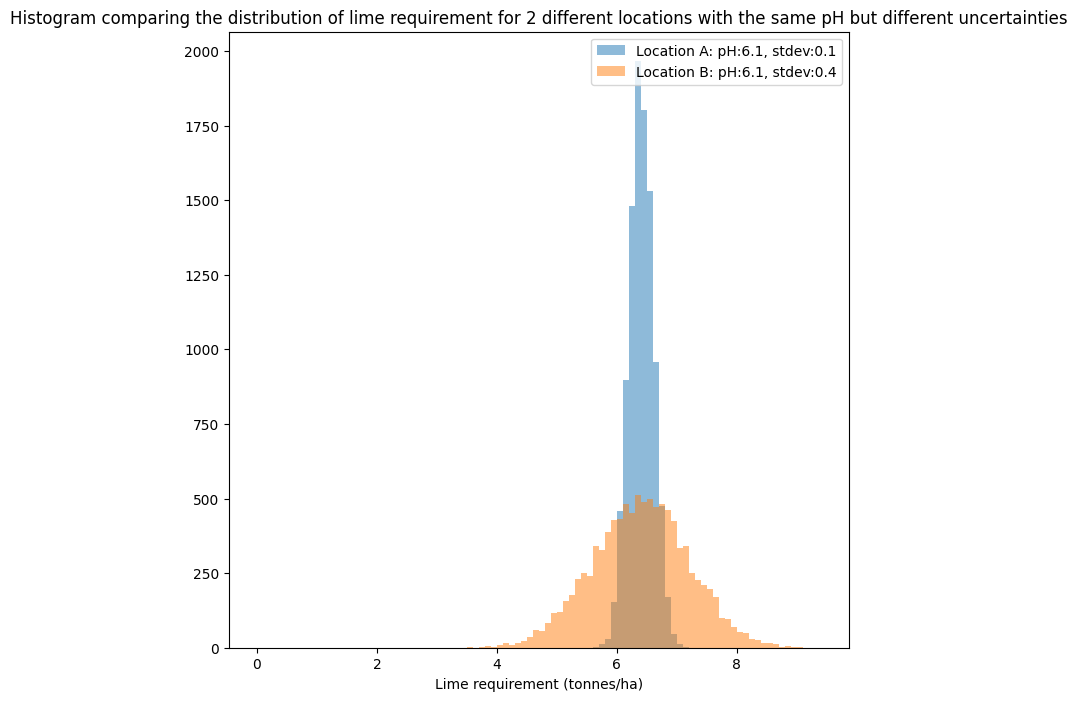

In [38]:
# randomly sample 10,000 values from the distribution
random_samples = np.random.normal(loc=loc_a_ph_mean, scale=loc_a_ph_stdev, size=10000)
limereq_a = lime_req_calc_vectorized(random_samples)

random_samples = np.random.normal(loc=loc_b_ph_mean, scale=loc_b_ph_stdev, size=10000)
limereq_b = lime_req_calc_vectorized(random_samples)

#plot the histogram
bins=np.arange(0,9.5,0.1)
plt.figure(figsize=(8,8))
plt.hist(limereq_a, bins=bins, alpha=0.5, label=f"Location A: pH:{np.format_float_positional(loc_a_ph_mean, 2)}, stdev:{np.format_float_positional(loc_a_ph_stdev, 2)}")
plt.hist(limereq_b, bins=bins, alpha=0.5, label=f"Location B: pH:{np.format_float_positional(loc_b_ph_mean, 2)}, stdev:{np.format_float_positional(loc_b_ph_stdev, 2)}")
plt.title("Histogram comparing the distribution of lime requirement for 2 different locations with the same pH but different uncertainties")
plt.xlabel("Lime requirement (tonnes/ha)")
#plt.vlines(x=0.9, ymin=0, ymax=2500, color = 'black')
#plt.text(0.95, 2000, "mean: 0.8", rotation=90, verticalalignment='center')
plt.legend(loc='upper right')
plt.show()




But what does this mean? Put simply, we are more certain that the Location B's lime requirement is close to the mean of 0.8 t/ha. From the data, we can ask questions such as "At a 50% confidence interval, what is my lime requirement for each location?"

In [39]:
from scipy import stats
print(f"There is a 50% chance that Location A's lime requirement is between {round_val(np.quantile(limereq_a, 0.25))} - {round_val(np.quantile(limereq_a, 0.75))} t/ha")
print(f"There is a 50% chance that Location B's lime requirement is between {round_val(np.quantile(limereq_b, 0.25))} - {round_val(np.quantile(limereq_b, 0.75))} t/ha")

There is a 50% chance that Location A's lime requirement is between 6.27 - 6.54 t/ha
There is a 50% chance that Location B's lime requirement is between 5.86 - 6.93 t/ha


However, even that does not tell the full story. We can see that there is a spike in the histogram around zero for location B. Because of the way the lime requirement calculation works, there is around a 16% chance that no lime is required for location B, whereas for location A, there is a zero percent chance:

In [40]:
loc_a_chance = np.count_nonzero(limereq_a == 0)/limereq_a.size*100
print(f"Chance that the lime requirement is 0t/ha for location A: {loc_a_chance}%")
print(f"Chance that the lime requirement is 0t/ha for location B: {(np.count_nonzero(limereq_b == 0))/limereq_b.size*100}%")

Chance that the lime requirement is 0t/ha for location A: 0.0%
Chance that the lime requirement is 0t/ha for location B: 0.0%


## Making the best use of uncertainty

Ultimately, how to utilise the uncertainty depends upon the specific situation. In the example above, if a resource constrained user could only apply lime to one location, they might select location B, because there is a ~16% chance that location A does not require lime. If a user was most concerned with a reliable crop response to liming, they may choose to apply lime at a rate of 0.8 t/ha to location B, because there is a higher chance that 0.8 t/ha is the optimal quantity for this location.
